In [22]:
from torch import Tensor
import torch
from torch.nn import functional as F
from torch import nn
from torch.utils.data import Dataset
import random
from tqdm.auto import tqdm
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
from torch.distributions import Categorical

In [23]:
def loss(
    beta_1: Tensor,
    t: Tensor,
    target: Tensor,
    model_output_probs: Tensor | None = None,
    model_output_logits: Tensor | None = None,
) -> Tensor:
    """
    Args:
        beta_1: Maximum possible accuracy (reached when t=1) of shape (batch_size,).
        t: A tensor representing the time step (batch_size,).
        target: Target tensor of shape (batch_size, seq_len, K).
        model_output_probs: Model output probabilities of shape (batch_size, seq_len, K). If None, model_output_logits must be provided.
        model_output_logits: Model output logits of shape (batch_size, seq_len, K). If None, model_output_probs must be provided.
    Returns:
        Loss value

    Must provide either model_output_probs or model_output_logits, but not both.
    """
    assert (
        model_output_probs is None or model_output_logits is None
    ), "Must provide either model_output_probs or model_output_logits, but not both"
    assert (
        model_output_probs is None or model_output_probs.shape == target.shape
    ), "model_output_probs must have the same shape as target if provided"
    assert (
        model_output_logits is None or model_output_logits.shape == target.shape
    ), "model_output_logits must have the same shape as target if provided"

    batch_size, seq_len, K = target.shape
    model_output = (
        model_output_probs
        if model_output_probs is not None
        else torch.softmax(model_output_logits, dim=-1)
    )
    result = torch.sum(
        K * beta_1 * t * torch.sum((target - model_output) ** 2) / (batch_size**2)
    )
    return result / seq_len

In [24]:
def beta_t(beta_1: Tensor, t: Tensor) -> Tensor:
    """
    Args:
        beta_1: Maximum possible accuracy (reached when t=1) of shape (batch_size,).
        t: A tensor representing the time step, where 1 corresponds to maximum accuracy of shape (batch_size,).
    Returns:
        Beta value at given time step t
    """
    assert beta_1.ndim == 1, "beta_1 should be a 1D tensor"
    assert t.ndim == 1, "t should be a 1D tensor"
    assert beta_1.shape == t.shape, "beta_1 and t should have the same shape"
    assert torch.all(t >= 0), "t must be at least 0"
    assert torch.all(t <= 1), "t must be at most 1"
    return beta_1 * (t**2)


def y_distribution(beta: Tensor, K: int, kron_x: Tensor) -> Tensor:
    """
    Args:
        beta: Tensor of accuracy values for each batch of shape (batch_size,).
        K: Number of classes (usually vocabulary size etc.)
        kron_x: One-hot encoded input tensor of shape (batch_size, seq_len, K).
    Returns:
        Noisy version of kron_x with the amount of noise controlled
        by beta. The shape of the output tensor is the same as kron_x, i.e., (batch_size, seq_len, K).
    """
    beta = beta.view(
        -1, 1, 1
    )  # allows for broadcasting with reach appropriate batch in kron_x
    mean = beta * (K * kron_x - 1)
    variance = beta * K
    epsilon = torch.normal(0, 1, kron_x.shape, device=kron_x.device)
    return mean + (variance**0.5) * epsilon


def theta(y: Tensor):
    """
    Args:
        y: Tensor of shape (batch_size, seq_len, K) representing the noisy version of kron_x.
    Returns:
        Tensor representing the scaled softmax of y, which is the input to the model.
    """
    assert y.ndim == 3, "y should be a 3D tensor of shape (batch_size, seq_len, K)"
    theta = F.softmax(y, dim=-1)
    theta = 2 * theta - 1  # scale to [-1, 1]
    return theta


def sample_t(batch_size, min_t=1e-6):
    return torch.clamp(torch.FloatTensor(batch_size).uniform_(0, 1), min=min_t)


def collate_fn(batch):
    """
    This collate function will truncate all sequences to the minimum length of
    the sequences in the batch

    Args:
        batch: List of dictionaries, each containing 'x', 't', and 'beta'.
    Returns:
        A dictionary with keys 'x', 't', 'beta_1' and 'theta', where 'x' is a tensor of shape
        (batch_size, seq_len, K), 't' is a tensor of shape (batch_size,), 'beta_1'
        is a tensor of shape (batch_size,), and 'theta' is the transformed version of 'x'.
    """
    x = [item["x"] for item in batch]
    min_length = min(seq.shape[0] for seq in x)
    x = [tensor[:min_length] for tensor in x]

    x = torch.stack(x, dim=0)  # Shape: (batch_size, seq_len, K)
    t = torch.cat([item["t"] for item in batch], dim=0)  # Shape: (batch_size,)
    beta = torch.cat([item["beta"] for item in batch], dim=0)
    beta_1 = torch.cat(
        [item["beta_1"] for item in batch], dim=0
    )  # Shape: (batch_size,)

    y = y_distribution(beta, x.shape[-1], x)  # Shape: (batch_size, seq_len, K)
    theta_tensor = theta(y)  # Shape: (batch_size, seq_len, K)

    return {"x": x, "t": t, "beta_1": beta_1, "theta": theta_tensor}

In [25]:
def dis_t(i: Tensor, n: Tensor, minimum: float = 1e-6):
    assert torch.all(i <= n), "i must be less than or equal to n"
    assert torch.all(n > 0), "n must be at least 1"
    assert torch.all(i > 0), "i must be at least 1"
    return torch.clamp((i - 1) / n, min=minimum)


def accuracy(i: Tensor, n: Tensor, beta_1: Tensor) -> Tensor:
    """
    Args:
        i: Current iteration number of shape (batch_size,).
        n: Total number of iterations of shape (batch_size,).
        beta_1: Maximum possible accuracy (reached when t=1) of shape (batch_size,).
    Returns:
        Accuracy at the current iteration i.
    """
    assert torch.all(n > 0), "Must have at least one inference step in total"
    assert torch.all(i > 0), "Must be on at least first inference step"
    assert torch.all(
        i <= n
    ), "Current iteration must be less than or equal to total iterations"

    return beta_1 * (2 * i - 1) / (n**2)


def sample_model_output(model_output_logits: Tensor) -> Tensor:
    """
    Args:
        model_output_logits: Model output logits of shape (batch_size, seq_len, K).
    Returns:
        Sampled model output based on the logits.
    """
    batch_size, seq_len, K = model_output_logits.shape
    dist = Categorical(logits=model_output_logits)
    samples = dist.sample()
    return F.one_hot(samples, K)


def y(sampled_one_hot: Tensor, accuracy: Tensor) -> Tensor:
    """
    Args:
        sampled_one_hot: Sampled output described by model logits that has been one-hot encoded,
                        of shape (batch_size, seq_len, K).
        accuracy: Accuracy at the current iteration of shape (batch_size,).
    Returns:
        Noisy version of the sampled one-hot tensor with the amount of noise controlled by accuracy.
        The shape of the output tensor is the same as sampled_one_hot, i.e., (batch_size, seq_len, K).
    """
    batch_size, seq_len, K = sampled_one_hot.shape
    accuracy = accuracy.view(-1, 1, 1)  # allows for broadcasting over batches
    mean = accuracy * (K * sampled_one_hot - 1)
    variance = accuracy * K
    epsilon = torch.normal(0, 1, sampled_one_hot.shape, device=sampled_one_hot.device)
    return mean + (variance**0.5) * epsilon


def bayesian_update(y: Tensor, model_input: Tensor, eps: float = 1e-8) -> Tensor:
    """
    Args:
        y: Noisy version of the sampled one-hot tensor of shape (batch_size, seq_len, K).
        model_input: Input to the model of shape (batch_size, seq_len, K).
    Returns:
        Resulting tensor after applying Bayesian update to the model input based on the noisy output y.
    """
    log_model_input = torch.log(model_input + eps)  # add eps to avoid log(0)
    z = y + log_model_input
    log_new_probs = F.log_softmax(z, dim=-1)
    res = torch.exp(log_new_probs)
    return res


def bayesian_inference(
    model_input: Tensor,
    model_output_logits: Tensor,
    i: Tensor,
    n: Tensor,
    beta_1: Tensor,
) -> Tensor:
    """
    Args:
        model_input: Input to the model of shape (batch_size, seq_len, K).
        model_output_logits: Model output logits of shape (batch_size, seq_len, K).
        i: Current iteration number of shape (batch_size,).
        n: Total number of iterations of shape (batch_size,).
        beta_1: Maximum possible accuracy (reached when t=1) of shape (batch_size,).
    Returns:
        Resulting tensor after performing Bayesian inference.
    """
    acc = accuracy(i, n, beta_1)
    sampled = sample_model_output(model_output_logits)
    noisy_y = y(sampled, acc)

    # we need to do `(model_input + 1) / 2` to convert the input from [-1, 1] to [0, 1]
    # if we did not, the parameters of the distribution wouldn't produce a valid probability distribution
    # and so the `bayesian_update` may end up with NaN values
    # however, upon returning, we need to convert it back to [-1, 1] as that is what the model is trained on
    return bayesian_update(noisy_y, (model_input + 1) / 2) * 2 - 1

In [26]:
class TokenizerBase:
    def vocab_size(self) -> int:
        raise NotImplementedError("This method should be implemented by subclasses.")

    def encode(self, text: str) -> Tensor:
        raise NotImplementedError("This method should be implemented by subclasses.")

    def decode(self, tokens: Tensor) -> str:
        raise NotImplementedError("This method should be implemented by subclasses.")

In [27]:
class DiscreteSyntheticTokenizer(TokenizerBase):
    # only tokenizes strings like " 8 , 9 , 1 0 , 1 1 , 1 2 ,"
    # this is intended to be used only with the discrete synthetic dataset
    def __init__(self):
        super().__init__()
        self.vocab = {",": 10}
        for i in range(10):
            key = str(i)
            value = i
            self.vocab[key] = value

        self.anti_vocab = {}
        for k in self.vocab:
            self.anti_vocab[self.vocab[k]] = k

    def vocab_size(self) -> int:
        return len(self.vocab)

    def encode(self, text: str) -> Tensor:
        splits = text.split()
        res = [self.vocab.get(s, 0) for s in splits]
        return torch.tensor(res, dtype=torch.long)

    def decode(self, tokens: Tensor) -> str:
        assert tokens.ndim == 2, "tokens should be a 2D tensor of shape (seq_len, K)"
        seq_len, K = tokens.shape
        cur_seq = []
        for i in range(seq_len):
            one_hot_encoding = tokens[i]
            value = torch.argmax(one_hot_encoding)
            cur_seq.append(self.anti_vocab.get(value.item(), ""))
        return " ".join(cur_seq)

In [28]:
class DiscreteSyntheticDataset(Dataset):
    def __init__(
        self,
        tokenizer: DiscreteSyntheticTokenizer,
        length: int = 32,
        tokenized_length: int = 32,
        mini: int = 0,
        maxi: int = 100,
        beta_1: float = 4.0,
        min_t: float = 1e-6,
    ):
        self.length = length
        self.tokenized_length = tokenized_length
        self.tokenizer = tokenizer
        self.mini = mini
        self.maxi = maxi
        self.min_t = min_t
        self.beta_1 = torch.tensor([beta_1])

    def generate_sequence(self):
        start = random.randint(self.mini, self.maxi - self.length)
        end = start + self.length
        acc = ""
        for i in range(start, end + 1):
            for c in str(i):
                acc += " " + c
            acc += " ,"
        tokenized = self.tokenizer.encode(acc)
        return tokenized[: self.tokenized_length]

    def __len__(self):
        return 10000

    def __getitem__(self, idx):
        seq = F.one_hot(
            self.generate_sequence(), num_classes=self.tokenizer.vocab_size()
        )
        t = sample_t(1, self.min_t)
        beta = beta_t(self.beta_1, t)
        return {"x": seq, "t": t, "beta": beta, "beta_1": self.beta_1}

In [29]:
class DiscreteModel(nn.Module):
    def __init__(
        self,
        max_seq_len: int,
        K: int,
        hidden_dim: int,
        num_heads: int,
        layers: int = 3,
        dropout: float = 0.1,
    ):
        super().__init__()
        assert hidden_dim % num_heads == 0, "hidden_dim must be divisble by num_heads"
        self.emb = nn.Parameter(torch.randn(K, hidden_dim))
        self.pos_emb = nn.Parameter(torch.randn(max_seq_len, hidden_dim))
        self.time_vec = nn.Parameter(torch.randn(1, hidden_dim))
        self.layers = nn.ModuleList(
            [
                nn.TransformerEncoderLayer(
                    hidden_dim,
                    num_heads,
                    hidden_dim * 4,
                    dropout,
                    batch_first=True,
                    bias=False,
                )
                for i in range(layers)
            ]
        )
        self.classifier = nn.Parameter(torch.randn(hidden_dim, K))

    def token_emb(self, x):
        return x @ self.emb

    def positional_emb(self, x):
        return x + self.pos_emb[: x.shape[1]]

    def time_emb(self, x, t):
        assert t.ndim == 1, "time vector `t` should be vector of length batch_size"
        # we need to first unsqueeze t to get it from shape (batch_size,)
        # to (batch_size, 1) so it is compatible with the time_vec's (1, hidden_dim)
        # the result is (batch_size, hidden_dim) however the x is
        # (batch_size, seq_len, hidden_dim) so we need a second unsqueeze
        return (t.unsqueeze(-1) @ self.time_vec).unsqueeze(-2) + x

    def forward(self, x, t):
        x = self.token_emb(x)
        x = self.positional_emb(x)
        x = self.time_emb(x, t)
        for i, l in enumerate(self.layers):
            x = l.forward(x)
        return F.relu(x @ self.classifier)

In [ ]:
# Training setup
tokenized_length = 12
length = tokenized_length * 2
device = "cuda" if torch.cuda.is_available() else "cpu"

# Initialize tokenizer and dataset
tokenizer = DiscreteSyntheticTokenizer()
dataset = DiscreteSyntheticDataset(
    tokenizer=tokenizer, length=length, tokenized_length=tokenized_length, beta_1=4.0
)

# Create data loader
dataloader = DataLoader(dataset, batch_size=8, shuffle=True, collate_fn=collate_fn)

# Initialize model
model = DiscreteModel(
    max_seq_len=32,
    K=tokenizer.vocab_size(),
    hidden_dim=128,
    num_heads=4,
    layers=3,
    dropout=0.1,
)
model = model.to(device)

# Initialize optimizer with warmup scheduler
target_lr = 1e-3
warmup_steps = 500
optimizer = torch.optim.Adam(model.parameters(), lr=target_lr)  # Start with target lr

# Learning rate scheduler with warmup
def get_lr_lambda(current_step):
    if current_step < warmup_steps:
        # Linear warmup from 0 to 1 (will be multiplied by base lr)
        return (current_step + 1) / warmup_steps
    else:
        # Maintain target learning rate after warmup
        return 1.0

scheduler = torch.optim.lr_scheduler.LambdaLR(optimizer, lr_lambda=get_lr_lambda)

print(f"Model parameters: {sum(p.numel() for p in model.parameters()):,}")
print(f"Vocab size: {tokenizer.vocab_size()}")
print(f"Dataset size: {len(dataset)}")
print(f"Target LR: {target_lr}, Warmup steps: {warmup_steps}")
print(f"Initial LR: {optimizer.param_groups[0]['lr']}")

# Training parameters
num_epochs = 3000
grad_clip_norm = 1.0  # Optional gradient clipping
losses = []
learning_rates = []  # Track learning rates

def train_discrete_model_notebook():
    model.train()
    train_iter = iter(dataloader)

    pbar = tqdm(range(num_epochs), desc="Training Discrete Model")

    for epoch in pbar:
        try:
            batch = next(train_iter)
        except StopIteration:
            train_iter = iter(dataloader)
            batch = next(train_iter)

        # Get batch data
        x = batch["x"]  # Target one-hot encoded sequences
        t = batch["t"]  # Time steps
        beta_1 = batch["beta_1"]  # Beta values
        model_input = batch["theta"]  # Input to model (noisy version)
        
        x = x.to(device)
        t = t.to(device)
        beta_1 = beta_1.to(device)
        model_input = model_input.to(device)

        # Forward pass
        output = model.forward(model_input, t)

        # Compute loss
        batch_loss = loss(
            beta_1=beta_1, t=t, target=x.float(), model_output_logits=output
        )

        # Backward pass
        optimizer.zero_grad()
        batch_loss.backward()

        # Optional gradient clipping
        if grad_clip_norm is not None:
            torch.nn.utils.clip_grad_norm_(model.parameters(), grad_clip_norm)

        optimizer.step()
        
        # Update learning rate scheduler
        scheduler.step()

        # Track metrics
        current_lr = optimizer.param_groups[0]['lr']
        losses.append(batch_loss.item())
        learning_rates.append(current_lr)

        # Update progress bar with current learning rate
        pbar_description = f"Loss: {batch_loss.item():.4f}, LR: {current_lr:.6f}"
        pbar.set_description(pbar_description)

    print("Training completed!")
    
    # Create visualization of learning rate schedule
    print("\nCreating learning rate visualization...")
    
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 8))
    
    # Plot learning rate over time
    ax1.plot(learning_rates, 'b-', linewidth=2, label='Learning Rate')
    ax1.axvline(x=warmup_steps, color='r', linestyle='--', alpha=0.7, label=f'Warmup End (step {warmup_steps})')
    ax1.set_xlabel('Training Step')
    ax1.set_ylabel('Learning Rate')
    ax1.set_title('Learning Rate Schedule with Warmup')
    ax1.legend()
    ax1.grid(True, alpha=0.3)
    ax1.set_yscale('log')  # Log scale to better see the warmup
    
    # Plot loss over time
    ax2.plot(losses, 'g-', linewidth=1, alpha=0.7, label='Training Loss')
    ax2.axvline(x=warmup_steps, color='r', linestyle='--', alpha=0.7, label=f'Warmup End (step {warmup_steps})')
    ax2.set_xlabel('Training Step')
    ax2.set_ylabel('Loss')
    ax2.set_title('Training Loss')
    ax2.legend()
    ax2.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    
    # Print some statistics
    print(f"\nLearning Rate Statistics:")
    print(f"Initial LR: {learning_rates[0]:.8f}")
    print(f"LR at warmup end (step {warmup_steps}): {learning_rates[warmup_steps-1]:.8f}")
    print(f"Final LR: {learning_rates[-1]:.8f}")
    print(f"Target LR: {target_lr:.8f}")
    
def visualize_lr_schedule_only():
    """Function to just visualize the learning rate schedule without training"""
    steps = range(1, 1001)  # First 1000 steps
    lrs = [target_lr * (step / warmup_steps) if step < warmup_steps else target_lr for step in steps]
    
    plt.figure(figsize=(10, 6))
    plt.plot(steps, lrs, 'b-', linewidth=2, label='Scheduled Learning Rate')
    plt.axvline(x=warmup_steps, color='r', linestyle='--', alpha=0.7, label=f'Warmup End (step {warmup_steps})')
    plt.xlabel('Training Step')
    plt.ylabel('Learning Rate')
    plt.title(f'Learning Rate Schedule: {warmup_steps} Warmup Steps to {target_lr}')
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.yscale('log')
    plt.show()
    
    print(f"Warmup schedule: Steps 1-{warmup_steps} ramp from {target_lr/warmup_steps:.8f} to {target_lr:.8f}")
    print(f"Post-warmup: Steps {warmup_steps+1}+ maintain {target_lr:.8f}")

print("\nUse train_discrete_model_notebook() to train with LR tracking and visualization")
print("Use visualize_lr_schedule_only() to just see the LR schedule without training")

Model parameters: 597,632
Vocab size: 11
Dataset size: 10000
Target LR: 0.001, Warmup steps: 500
Initial LR: 2e-06

Use train_discrete_model_notebook() to train with LR tracking and visualization
Use visualize_lr_schedule_only() to just see the LR schedule without training


Training Discrete Model:   0%|          | 0/3000 [00:00<?, ?it/s]

Epoch 0: Loss=46.1444, LR=0.00000400
Epoch 100: Loss=20.9921, LR=0.00020400
Epoch 100: Loss=20.9921, LR=0.00020400
Epoch 200: Loss=7.9752, LR=0.00040400
Epoch 200: Loss=7.9752, LR=0.00040400
Epoch 300: Loss=7.8950, LR=0.00060400
Epoch 300: Loss=7.8950, LR=0.00060400
Epoch 400: Loss=9.7904, LR=0.00080400
Epoch 400: Loss=9.7904, LR=0.00080400
Epoch 500: Loss=6.9048, LR=0.00100000
Epoch 500: Loss=6.9048, LR=0.00100000
Epoch 600: Loss=10.0436, LR=0.00100000
Epoch 600: Loss=10.0436, LR=0.00100000
Epoch 700: Loss=8.3558, LR=0.00100000
Epoch 700: Loss=8.3558, LR=0.00100000
Epoch 800: Loss=8.3201, LR=0.00100000
Epoch 800: Loss=8.3201, LR=0.00100000
Epoch 900: Loss=4.9813, LR=0.00100000
Epoch 900: Loss=4.9813, LR=0.00100000
Epoch 1000: Loss=10.0709, LR=0.00100000
Epoch 1000: Loss=10.0709, LR=0.00100000
Epoch 1100: Loss=7.4053, LR=0.00100000
Epoch 1100: Loss=7.4053, LR=0.00100000
Epoch 1200: Loss=9.5273, LR=0.00100000
Epoch 1200: Loss=9.5273, LR=0.00100000
Epoch 1300: Loss=7.8515, LR=0.00100000


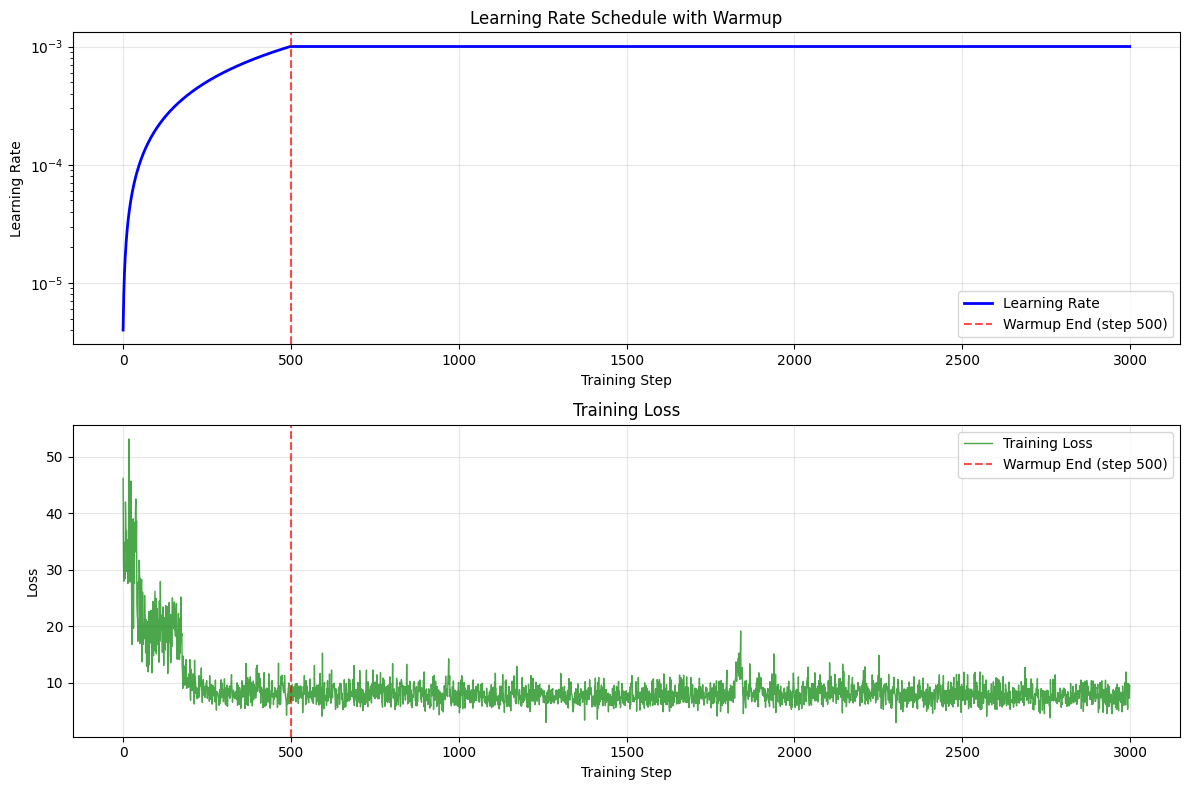


Learning Rate Statistics:
Initial LR: 0.00000400
LR at warmup end (step 500): 0.00100000
Final LR: 0.00100000
Target LR: 0.00100000


In [31]:
# Start training
train_discrete_model_notebook()

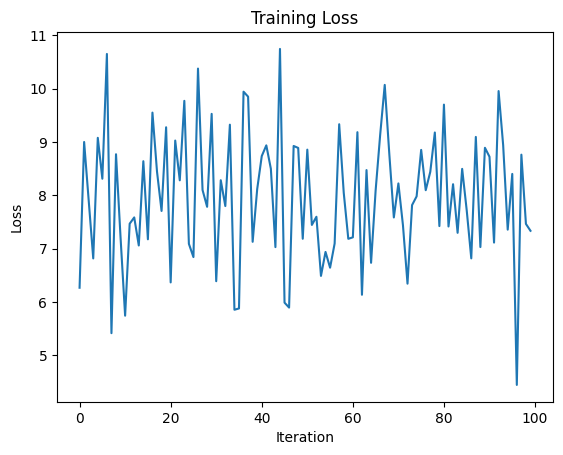

In [40]:
plt.plot(losses)
plt.xlabel("Iteration")
plt.ylabel("Loss")
plt.title("Training Loss")
plt.show()

In [33]:
model_input = torch.normal(0, 1, (1, tokenized_length, tokenizer.vocab_size()), device=device)
model_input = torch.softmax(model_input, dim=-1) * 2 - 1

In [34]:
n = 100

In [35]:
for i in tqdm(range(1, n + 1)):
    if i % 10 == 0:
        tqdm.write(tokenizer.decode(model_input.squeeze(0)))
    cur_it = torch.tensor([i], device=device)
    total_it = torch.tensor([n], device=device)
    t = dis_t(cur_it, total_it).to(device)
    dis_beta_1 = torch.ones_like(t, device=device) * 0.55

    current_model_input = model_input.clone()

    model_output = model.forward(model_input, t)
    model_input = bayesian_inference(
        model_input, model_output, cur_it, total_it, dis_beta_1
    )

tqdm.write("Final model result:")
tqdm.write(tokenizer.decode(model_input.squeeze(0)))

  0%|          | 0/100 [00:00<?, ?it/s]

3 2 6 5 5 0 3 1 7 2 6 2
0 2 4 5 8 0 3 1 6 2 6 5
0 2 , 5 8 0 3 1 6 2 9 2
, , , 5 8 0 3 5 6 5 7 ,
0 2 , 5 8 0 3 1 6 2 9 2
, , , 5 8 0 3 5 6 5 7 ,
6 , , 2 8 0 3 5 6 5 8 ,
2 2 , 2 8 9 3 5 6 5 8 ,
6 , , 2 8 0 3 5 6 5 8 ,
2 2 , 2 8 9 3 5 6 5 8 ,
2 6 6 2 8 9 3 5 7 7 6 ,
2 6 , 2 8 9 3 5 , 7 7 ,
2 6 6 2 8 9 3 5 7 7 6 ,
2 6 , 2 8 9 3 5 , 7 7 ,
6 1 , 2 8 0 3 5 , 7 3 ,
6 1 , 2 1 0 1 5 , 7 3 ,
Final model result:
6 6 , 2 1 0 1 5 , 7 3 ,
6 1 , 2 8 0 3 5 , 7 3 ,
6 1 , 2 1 0 1 5 , 7 3 ,
Final model result:
6 6 , 2 1 0 1 5 , 7 3 ,
